# Perhitungan Skor RNN-IDS

## Import All Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import math

## Load All the Data

In [2]:
df_pred = pd.read_csv('/home/apta/neuralnetwork-AD/rnn-apta/results/vector/Combine_Control_Monday-WorkingHours_training_21/result-lstm-tcp21-hl2-seq2-do0.2-oov3500-Thursday-WorkingHours_testing_21.csv', 
                      names=['id', 'binary_error', 'b_mean', 'b_iqr', 'b_zscore', 'floatin_error', 'f_mean', 'f_iqr', 'f_zscore'])

df_truth = pd.read_csv('/home/apta/CIC-IDS-2017/CSVs/TrafficLabelling/Thursday-WorkingHours.pcap_ISCX.csv', 
                       encoding='ISO-8859-1')


/tmp/ipykernel_220134/2162718851.py:4: DtypeWarning: Columns (0,1,3,6,84) have mixed types. Specify dtype option on import or set low_memory=False.
  df_truth = pd.read_csv('/home/apta/CIC-IDS-2017/CSVs/TrafficLabelling/Thursday-WorkingHours.pcap_ISCX.csv',


In [3]:
df_pred.head()

,id,binary_error,b_mean,b_iqr,b_zscore,floatin_error,f_mean,f_iqr,f_zscore
0,192.168.10.14-59136-192.168.10.50-21-tcp,0.701149,1,1,1,18461.882353,0,1,1
1,192.168.10.9-1062-192.168.10.50-21-tcp,0.689655,1,1,1,31488.329412,0,1,1
2,192.168.10.5-49227-192.168.10.50-21-tcp,0.701149,1,1,1,25038.905882,0,1,1
3,192.168.10.17-38831-192.168.10.50-21-tcp,0.689655,1,1,1,15458.988235,0,1,1
4,192.168.10.8-49200-192.168.10.50-21-tcp,0.701149,1,1,1,32431.305882,0,1,1


In [4]:
df_truth.head()

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.12-192.168.10.50-60148-22-6,192.168.10.12,60148.0,192.168.10.50,22.0,6.0,6/7/2017 1:00,166.0,1.0,1.0,...,32.0,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,BENIGN
1,192.168.10.12-192.168.10.50-60148-22-6,192.168.10.50,22.0,192.168.10.12,60148.0,6.0,6/7/2017 1:00,83.0,1.0,2.0,...,32.0,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,BENIGN
2,192.168.10.12-91.189.89.199-123-123-17,192.168.10.12,123.0,91.189.89.199,123.0,17.0,6/7/2017 1:00,99947.0,1.0,1.0,...,40.0,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,BENIGN
3,192.168.10.12-72.38.129.202-123-123-17,192.168.10.12,123.0,72.38.129.202,123.0,17.0,6/7/2017 1:00,37017.0,1.0,1.0,...,32.0,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,BENIGN
4,8.0.6.4-8.6.0.1-0-0-0,8.6.0.1,0.0,8.0.6.4,0.0,0.0,6/7/2017 1:00,111161336.0,147.0,0.0,...,0.0,1753752.625,2123197.578,4822992.0,95.0,9463032.7,2657727.996,13600000.0,5700287.0,BENIGN


In [5]:
df_pred[['b_iqr']].value_counts()

b_iqr
1        531
Name: count, dtype: int64

## Exploratory Data Analysis

In [6]:
df_pred[['b_iqr']].value_counts()

b_iqr
1        531
Name: count, dtype: int64

In [7]:
df_pred[['b_zscore']].value_counts()

b_zscore
1           531
Name: count, dtype: int64

In [8]:
df_truth.isnull().sum()

Flow ID              288602
 Source IP           288602
 Source Port         288602
 Destination IP      288602
 Destination Port    288602
                      ...  
Idle Mean            288602
 Idle Std            288602
 Idle Max            288602
 Idle Min            288602
 Label               288602
Length: 85, dtype: int64

## Data Pre-Processing

### Convert the type of the data

In [9]:
df_truth.columns = df_truth.columns.str.strip()  # remove leading/trailing spaces
df_truth.columns = df_truth.columns.str.replace(' ', '_')  # optional: make them easier to type

df_truth['Source_Port'] = pd.to_numeric(df_truth['Source_Port'], errors='coerce')
df_truth['Destination_Port'] = pd.to_numeric(df_truth['Destination_Port'], errors='coerce')

# Optionally: drop rows with NaN in these columns
df_truth.dropna(subset=['Source_Port', 'Destination_Port'], inplace=True)

# Filter to only include rows where either port is 21
df_truth = df_truth[(df_truth['Source_Port'] == 21) | (df_truth['Destination_Port'] == 21)]

# Now you can safely convert to int
df_truth['Source_Port'] = df_truth['Source_Port'].astype(int)
df_truth['Destination_Port'] = df_truth['Destination_Port'].astype(int)


df_truth.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1841 entries, 32 to 458916
Data columns (total 85 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Flow_ID                      1841 non-null   object 
 1   Source_IP                    1841 non-null   object 
 2   Source_Port                  1841 non-null   int64  
 3   Destination_IP               1841 non-null   object 
 4   Destination_Port             1841 non-null   int64  
 5   Protocol                     1841 non-null   float64
 6   Timestamp                    1841 non-null   object 
 7   Flow_Duration                1841 non-null   float64
 8   Total_Fwd_Packets            1841 non-null   float64
 9   Total_Backward_Packets       1841 non-null   float64
 10  Total_Length_of_Fwd_Packets  1841 non-null   float64
 11  Total_Length_of_Bwd_Packets  1841 non-null   float64
 12  Fwd_Packet_Length_Max        1841 non-null   float64
 13  Fwd_Packet_Length_Mi

In [10]:
df_truth['Label'].head()

32     BENIGN
36     BENIGN
38     BENIGN
939    BENIGN
941    BENIGN
Name: Label, dtype: object

In [11]:
df_truth['Source_Port'] = df_truth['Source_Port'].astype(str)
df_truth['Destination_Port'] = df_truth['Destination_Port'].astype(str)

df_truth['Protocol'] = pd.to_numeric(df_truth['Protocol'], errors='coerce')  
df_truth.dropna(subset=['Protocol'], inplace=True)                      
df_truth['Protocol'] = df_truth['Protocol'].astype(int).astype(str)         

protocol_map = {
    '6': 'tcp',
    '17': 'udp',
    '1': 'icmp',
    '0': 'other'  # fallback or unknown
}

# Convert 'Protocol' number to string using the mapping
def map_protocol(protocol):
    return protocol_map.get(protocol, 'other')

# Apply the conversion for 'Protocol' and concatenate the 'id'
df_truth['id'] = df_truth[['Source_IP', 'Source_Port', 'Destination_IP', 'Destination_Port', 'Protocol']]\
    .astype(str).apply(lambda row: "-".join([row[0], row[1], row[2], row[3], map_protocol(row[4])]), axis=1)

/tmp/ipykernel_220134/691346611.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  .astype(str).apply(lambda row: "-".join([row[0], row[1], row[2], row[3], map_protocol(row[4])]), axis=1)


## Making Predictions

In [12]:
df_pred["id"]

0      192.168.10.14-59136-192.168.10.50-21-tcp
1        192.168.10.9-1062-192.168.10.50-21-tcp
2       192.168.10.5-49227-192.168.10.50-21-tcp
3      192.168.10.17-38831-192.168.10.50-21-tcp
4       192.168.10.8-49200-192.168.10.50-21-tcp
                         ...                   
526    192.168.10.19-52812-192.168.10.50-21-tcp
527    192.168.10.15-61326-192.168.10.50-21-tcp
528      192.168.10.9-9925-192.168.10.50-21-tcp
529      192.168.10.8-2530-192.168.10.50-21-tcp
530    192.168.10.16-59012-192.168.10.50-21-tcp
Name: id, Length: 531, dtype: object

In [13]:
df_truth["id"]

# df_truth[df_truth["id"] == "192.168.10.50-21-172.16.0.1-52120-tcp"]

32         192.168.10.5-53430-192.168.10.50-21-tcp
36         192.168.10.50-21-192.168.10.5-53430-tcp
38         192.168.10.5-53430-192.168.10.50-21-tcp
939       192.168.10.15-55585-192.168.10.50-21-tcp
941       192.168.10.50-21-192.168.10.15-55585-tcp
                            ...                   
458806    192.168.10.50-21-192.168.10.16-49566-tcp
458807    192.168.10.50-21-192.168.10.16-49566-tcp
458912     192.168.10.8-52345-192.168.10.50-21-tcp
458915     192.168.10.50-21-192.168.10.8-52345-tcp
458916     192.168.10.8-52345-192.168.10.50-21-tcp
Name: id, Length: 1841, dtype: object

In [14]:
# Convert 'Label' column to numeric: BENIGN -> 0, other -> 1
df_truth['Label'] = df_truth['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

In [15]:
# df_pred["Label"] = np.where(df_pred["id"].isin(df_truth["id"]), 1, 0)

df_pred = df_pred.merge(df_truth[['id', 'Label']], on='id', how='left')
df_pred = df_pred.dropna(subset=['Label'])

In [16]:
df_pred[df_pred['Label']==1]

,id,binary_error,b_mean,b_iqr,b_zscore,floatin_error,f_mean,f_iqr,f_zscore,Label


In [17]:
df_pred[df_pred['Label']==0]

,id,binary_error,b_mean,b_iqr,b_zscore,floatin_error,f_mean,f_iqr,f_zscore,Label
0,192.168.10.14-59136-192.168.10.50-21-tcp,0.701149,1,1,1,18461.882353,0,1,1,0
1,192.168.10.14-59136-192.168.10.50-21-tcp,0.701149,1,1,1,18461.882353,0,1,1,0
2,192.168.10.9-1062-192.168.10.50-21-tcp,0.689655,1,1,1,31488.329412,0,1,1,0
3,192.168.10.9-1062-192.168.10.50-21-tcp,0.689655,1,1,1,31488.329412,0,1,1,0
4,192.168.10.5-49227-192.168.10.50-21-tcp,0.701149,1,1,1,25038.905882,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...
1108,192.168.10.8-2530-192.168.10.50-21-tcp,0.689655,1,1,1,19813.623529,0,1,1,0
1109,192.168.10.8-2530-192.168.10.50-21-tcp,0.689655,1,1,1,19813.623529,0,1,1,0
1110,192.168.10.8-2530-192.168.10.50-21-tcp,0.689655,1,1,1,19813.623529,0,1,1,0
1111,192.168.10.16-59012-192.168.10.50-21-tcp,0.701149,1,1,1,27470.529412,0,1,1,0


In [18]:
df_pred

,id,binary_error,b_mean,b_iqr,b_zscore,floatin_error,f_mean,f_iqr,f_zscore,Label
0,192.168.10.14-59136-192.168.10.50-21-tcp,0.701149,1,1,1,18461.882353,0,1,1,0
1,192.168.10.14-59136-192.168.10.50-21-tcp,0.701149,1,1,1,18461.882353,0,1,1,0
2,192.168.10.9-1062-192.168.10.50-21-tcp,0.689655,1,1,1,31488.329412,0,1,1,0
3,192.168.10.9-1062-192.168.10.50-21-tcp,0.689655,1,1,1,31488.329412,0,1,1,0
4,192.168.10.5-49227-192.168.10.50-21-tcp,0.701149,1,1,1,25038.905882,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...
1108,192.168.10.8-2530-192.168.10.50-21-tcp,0.689655,1,1,1,19813.623529,0,1,1,0
1109,192.168.10.8-2530-192.168.10.50-21-tcp,0.689655,1,1,1,19813.623529,0,1,1,0
1110,192.168.10.8-2530-192.168.10.50-21-tcp,0.689655,1,1,1,19813.623529,0,1,1,0
1111,192.168.10.16-59012-192.168.10.50-21-tcp,0.701149,1,1,1,27470.529412,0,1,1,0


In [19]:
df_pred[['Label']].value_counts()

Label
0        1113
Name: count, dtype: int64

In [20]:
import os
# Define the directory path
dir_path = '../mcnemar/ftp'

# Check if the directory exists, and if not, create it
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

df_temp = df_pred[['id', 'b_mean','b_iqr', 'b_zscore', 'f_zscore', 'f_mean','f_iqr' ]]
df_temp.to_csv(os.path.join(dir_path, 'pred_0.0.csv'))

## Calculating Score

In [21]:
threshold = ['b_mean', 'b_iqr', 'b_zscore']
threshold_2 = ['f_mean', 'f_iqr', 'f_zscore']

methods = ['binary', 'floating']

In [22]:
df_pred[['b_zscore']]

,b_zscore
0,1
1,1
2,1
3,1
4,1
...,...
1108,1
1109,1
1110,1
1111,1


### Detection Rate

In [23]:
from sklearn.metrics import recall_score

score = dict()
score['Detection Rate'] = dict()
for method in methods:
    if method == 'binary':
        for i in threshold:
            acc = recall_score(df_pred['Label'], df_pred[i])
            score['Detection Rate'][i] = acc
            print(f'Recall-Binary-{i}: {acc}')
    else:
        for i in threshold_2:
            acc = recall_score(df_pred['Label'], df_pred[i])
            score['Detection Rate'][i] = acc
            print(f'Recall-Floating-{i}: {acc}')  

Recall-Binary-b_mean: 0.0
Recall-Binary-b_iqr: 0.0
Recall-Binary-b_zscore: 0.0
Recall-Floating-f_mean: 0.0
Recall-Floating-f_iqr: 0.0
Recall-Floating-f_zscore: 0.0


/home/apta/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/apta/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/apta/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/apta/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:15

### Confussion Matrix

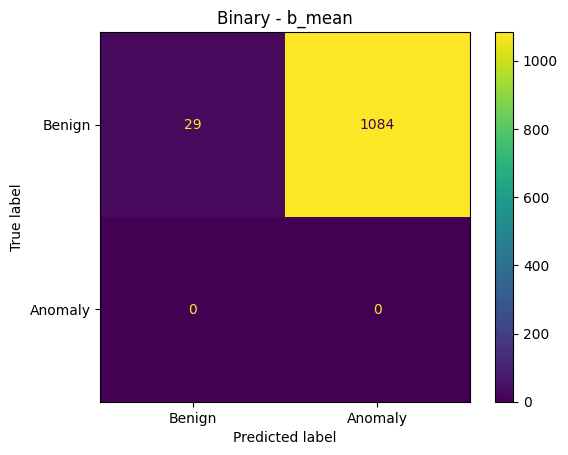

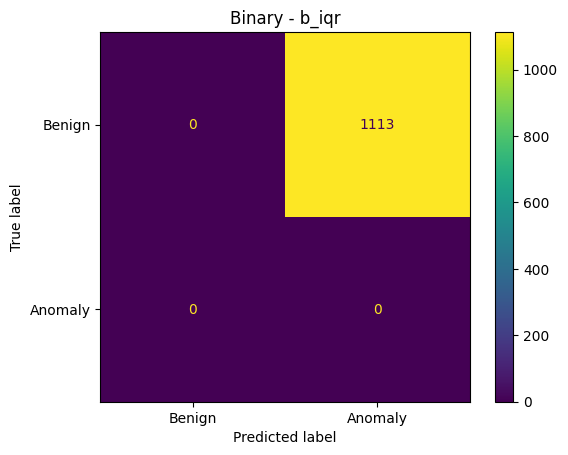

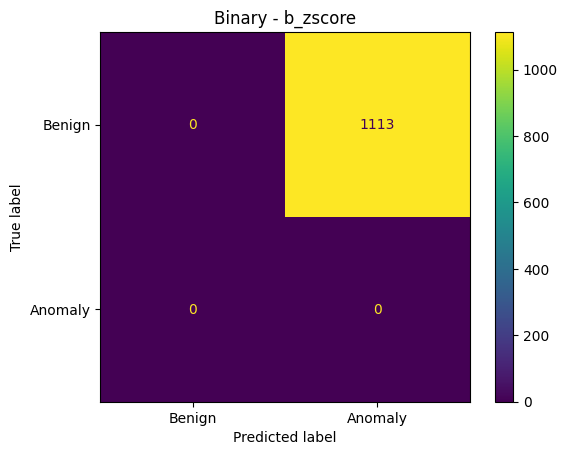

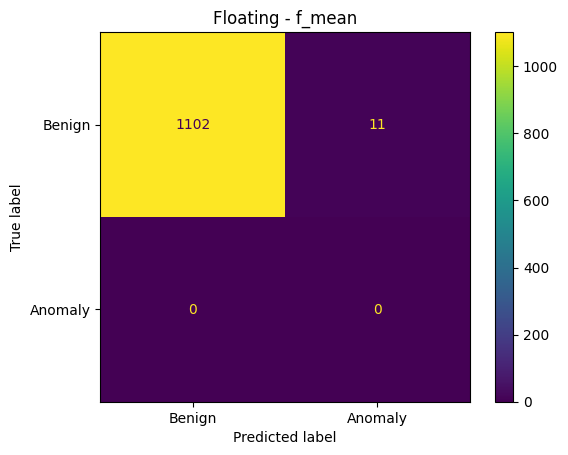

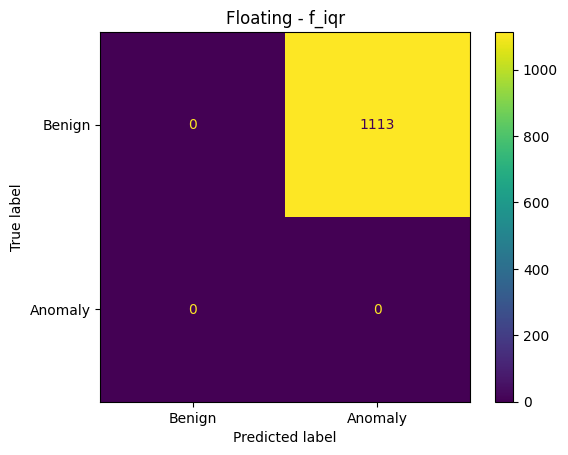

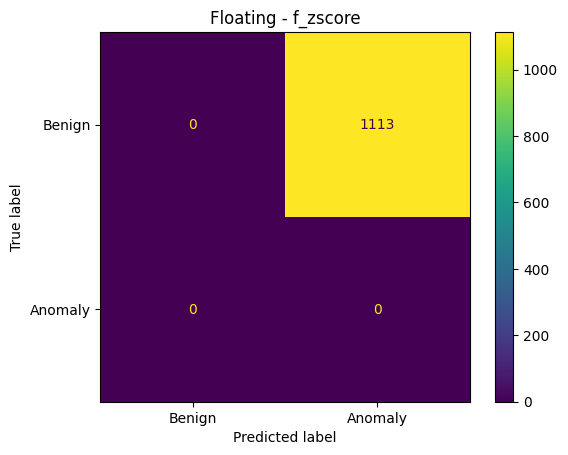

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

for method in methods:
    if method == 'binary':
        for i in threshold:
            conf_matrix = confusion_matrix(df_pred['Label'], df_pred[i])
            cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels=['Benign', 'Anomaly'])
            cm_display.plot()
            plt.title(f'Binary - {i.strip()}')
            plt.show()
    else:
        for i in threshold_2:
            conf_matrix = confusion_matrix(df_pred['Label'], df_pred[i])
            cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels=['Benign', 'Anomaly'])
            cm_display.plot()
            plt.title(f'Floating - {i.strip()}')
            plt.show()


### F2-Score

In [25]:
score['F2 Score'] = dict()
for method in methods:
    if method == 'binary':
        for i in threshold:
            tn, fp, fn, tp = confusion_matrix(df_pred['Label'], df_pred[i]).ravel()
            f2 = ((1+2**2)*tp)/((1+2**2)*tp+2**2*fn+fp)
            score['F2 Score'][i] = f2
            print(f'F2-Binary-{i}: {f2}')
    else:
        for i in threshold_2:
            tn, fp, fn, tp = confusion_matrix(df_pred['Label'], df_pred[i]).ravel()
            f2 = ((1+2**2)*tp)/((1+2**2)*tp+2**2*fn+fp)
            score['F2 Score'][i] = f2
            print(f'F2-Floating-{i}: {f2}')

F2-Binary-b_mean: 0.0
F2-Binary-b_iqr: 0.0
F2-Binary-b_zscore: 0.0
F2-Floating-f_mean: 0.0
F2-Floating-f_iqr: 0.0
F2-Floating-f_zscore: 0.0


### FPR Score

In [26]:
score['FPR Score'] = dict()
for method in methods:
    if method == 'binary':
        for i in threshold:
            tn, fp, fn, tp = confusion_matrix(df_pred['Label'], df_pred[i]).ravel()
            fpr = fp/(fp+tn)
            score['FPR Score'][i] = fpr
            print(f'FPR-Binary-{i}: {fpr}')
    else:
        for i in threshold_2:
            tn, fp, fn, tp = confusion_matrix(df_pred['Label'], df_pred[i]).ravel()
            fpr = fp/(fp+tn)
            score['FPR Score'][i] = fpr
            print(f'FPR-Floating-{i}: {fpr}')

FPR-Binary-b_mean: 0.9739442946990117
FPR-Binary-b_iqr: 1.0
FPR-Binary-b_zscore: 1.0
FPR-Floating-f_mean: 0.009883198562443846
FPR-Floating-f_iqr: 1.0
FPR-Floating-f_zscore: 1.0


In [27]:
from sklearn.metrics import accuracy_score

score['Accuracy Score'] = dict()
for method in methods:
    if method == 'binary':
        for i in threshold:
            acc = accuracy_score(df_pred['Label'], df_pred[i])
            score['Accuracy Score'][i] = acc
            print(f'Accuracy-Binary-{i}: {acc}')
    else:
        for i in threshold_2:
            acc = accuracy_score(df_pred['Label'], df_pred[i])
            score['Accuracy Score'][i] = acc
            print(f'Accuracy-Floating-{i}: {acc}')  

Accuracy-Binary-b_mean: 0.02605570530098832
Accuracy-Binary-b_iqr: 0.0
Accuracy-Binary-b_zscore: 0.0
Accuracy-Floating-f_mean: 0.9901168014375562
Accuracy-Floating-f_iqr: 0.0
Accuracy-Floating-f_zscore: 0.0


In [28]:
df_score = pd.DataFrame.from_dict(score)
df_score

,Detection Rate,F2 Score,FPR Score,Accuracy Score
b_mean,0.0,0.0,0.973944,0.026056
b_iqr,0.0,0.0,1.000000,0.000000
b_zscore,0.0,0.0,1.000000,0.000000
f_mean,0.0,0.0,0.009883,0.990117
f_iqr,0.0,0.0,1.000000,0.000000
f_zscore,0.0,0.0,1.000000,0.000000


In [29]:
df_score.to_excel('score_ftp_0.0.xlsx')

In [30]:
# %pip install openpyxl